# TensorFlow Probability Integration
This notebook demonstrates how to perform Markov chain Monte Carlo (MCMC) inference for Gaussian process models using TensorFlow Probability <strong data-cite="lao2020tfp">Lao et al. (2020)</strong>.

In [1]:
from pprint import PrettyPrinter

import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx
from gpjax.utils import dict_array_coercion

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)
key = jr.PRNGKey(123)

## Dataset

In this tutorial we'll be trying to model a normalised sinc function
$$f(x) = \frac{\sin(\pi x)}{\pi x}, \qquad x\in\mathbb{R}\setminus\{0\}, $$

through observations perturbed by Gaussian noise. We begin by simulating some data below.

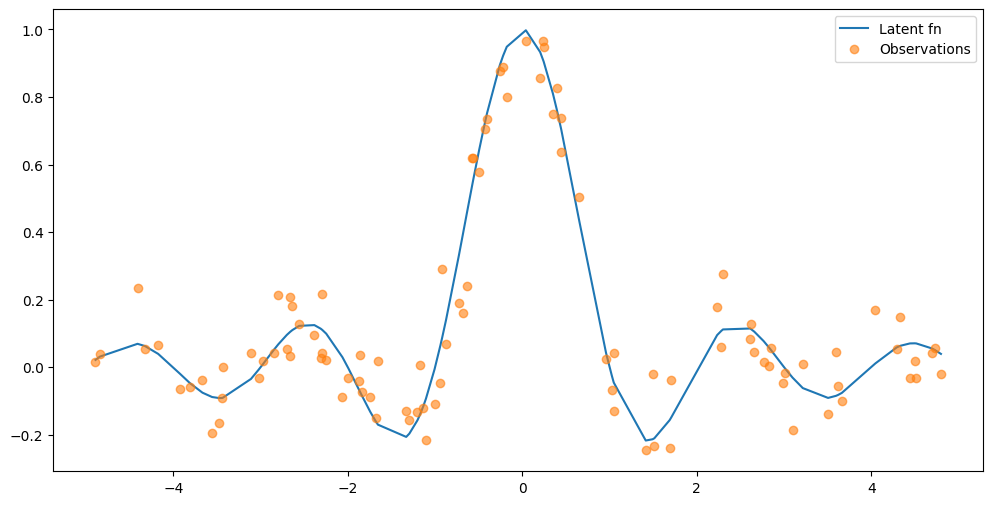

In [2]:
n = 100
noise = 0.1

x = jnp.sort(jr.uniform(key, minval=-5.0, maxval=5.0, shape=(n, 1)), axis=0)
f = lambda x: jnp.sin(jnp.pi * x) / (jnp.pi * x)
y = f(x) + jr.normal(key, shape=x.shape) * noise

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, f(x), label="Latent fn")
ax.plot(x, y, "o", label="Observations", alpha=0.6)
ax.legend(loc="best")

## Define GPJax objects

We'll wrap our pair of observed data arrays up into a `Dataset` object $\mathcal{D}$ and define a GP posterior.

In [3]:
D = Dataset(X=x, y=y)
likelihood = gpx.Gaussian(num_datapoints=D.n)
posterior = gpx.Prior(kernel=jk.RBF()) * likelihood

## Initialise parameters

Since our model hyperparameters are positive, our MCMC sampler will sample on the parameters' unconstrained space and the samples will then be back-transformed onto the original positive real line. GPJax's `initialise` function makes this straightforward.

In [4]:
params, _, bijectors = gpx.initialise(posterior, key).unpack()

### Parameter type

MCMC samplers supplied with TensorFlow probability require us to supply our parameters as an array.
This is at odds with GPJax where our parameters are stored as dictionaries.
To resolve this, we use the `dict_array_coercion` callable that returns two functions; one that maps from an array to a dictionary and a second that maps back to an array given a dictionary.
These functions are order preserving.

In [5]:
dict_to_array, array_to_dict = dict_array_coercion(params)

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_99258/3425936530.py:1: DeprecatedWarning: dict_array_coercion is deprecated as of 0.5.6 and will be removed in 0.6.0. Use method from jaxutils.config instead.
  dict_to_array, array_to_dict = dict_array_coercion(params)


In [6]:
parray = dict_to_array(params)
print(parray)

[Array([1.], dtype=float64), Array([1.], dtype=float64), Array([1.], dtype=float64)]


In [7]:
array_to_dict(parray) == params

True

### Specifying priors

We can define Gamma priors on our hyperparameters through TensorFlow Probability's `Distributions` module. We transform these to the unconstained space via `tfd.TransformedDistribution`.

In [8]:
import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.jax.bijectors as tfb

tfd = tfp.distributions

priors = gpx.parameters.copy_dict_structure(params)
priors["kernel"]["lengthscale"] = tfd.TransformedDistribution(
    tfd.Gamma(concentration=jnp.array(1.0), rate=jnp.array(1.0)), tfb.Softplus()
)
priors["kernel"]["variance"] = tfd.TransformedDistribution(
    tfd.Gamma(concentration=jnp.array(1.0), rate=jnp.array(1.0)), tfb.Softplus()
)
priors["likelihood"]["obs_noise"] = tfd.TransformedDistribution(
    tfd.Gamma(concentration=jnp.array(1.0), rate=jnp.array(1.0)), tfb.Softplus()
)

### Defining our target function

We now define the marginal likelihood for the target distribution that our MCMC sampler will sample from. For our GP, this is the marginal log-likelihood that we specify below.

In [9]:
log_mll = posterior.marginal_log_likelihood(D, negative=False)
log_mll(params)

Array(-103.28185178, dtype=float64)

Since our model parameters are now an array, not a dictionary, we must define a function that maps the array back to a dictionary and then evaluates the marginal log-likelihood. Using the second return of `dict_array_coercion` this is straightforward as follows.

In [10]:
from gpjax.parameters import evaluate_priors


def build_log_pi(log_mll, unconstrained_priors, mapper_fn):
    def array_mll(parameter_array):

        # Convert parameter array to a dictionary:
        params_dict = mapper_fn([jnp.array(i) for i in parameter_array])

        # Evaluate the log prior, log p(θ):
        log_hyper_prior_eval = evaluate_priors(
            params_dict, unconstrained_priors
        )

        # Evaluate the log-likelihood probability kernel, log [p(y|f,  θ) p(f|  θ)]:
        log_mll_eval = log_mll(gpx.constrain(params_dict, bijectors))

        return log_mll_eval + log_hyper_prior_eval

    return array_mll


mll_array_form = build_log_pi(log_mll, priors, array_to_dict)

## Sample

We now have all the necessary machinery in place. To sample from our target distribution, we'll use TensorFlow's Hamiltonian Monte-Carlo sampler equipped with the No U-Turn Sampler kernel to draw 500 samples for illustrative purposes (you will likely need more in practice).

In [11]:
n_samples = 500


def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(mll_array_form, 1e-1)
    return tfp.mcmc.sample_chain(
        n_samples,
        current_state=state,
        kernel=kernel,
        trace_fn=lambda _, results: results.target_log_prob,
        seed=key,
    )

Since everything is pure Jax, we are free to JIT compile our sampling function and go.

In [12]:
unconstrained_params = gpx.unconstrain(params, bijectors)
states, log_probs = jax.jit(run_chain)(
    key, jnp.array(dict_to_array(unconstrained_params))
)
states, log_probs = jax.jit(run_chain)(key, jnp.array(dict_to_array(params)))

## Inspecting samples

We now assess the quality of our chains. To illustrate the acts of burn-in and thinning, we discard the first 50 samples as burn-in and thin the remaining samples by a factor of 2.

In [13]:
burn_in = 50
thin_factor = 2
n_params = states.shape[1]

samples = [states[burn_in:, i, :][::thin_factor] for i in range(n_params)]
sample_dict = array_to_dict(samples)
constrained_samples = gpx.constrain(sample_dict, bijectors)
constrained_sample_list = dict_to_array(constrained_samples)

We observe reasonable performance for our chains as shown in the traceplots below.

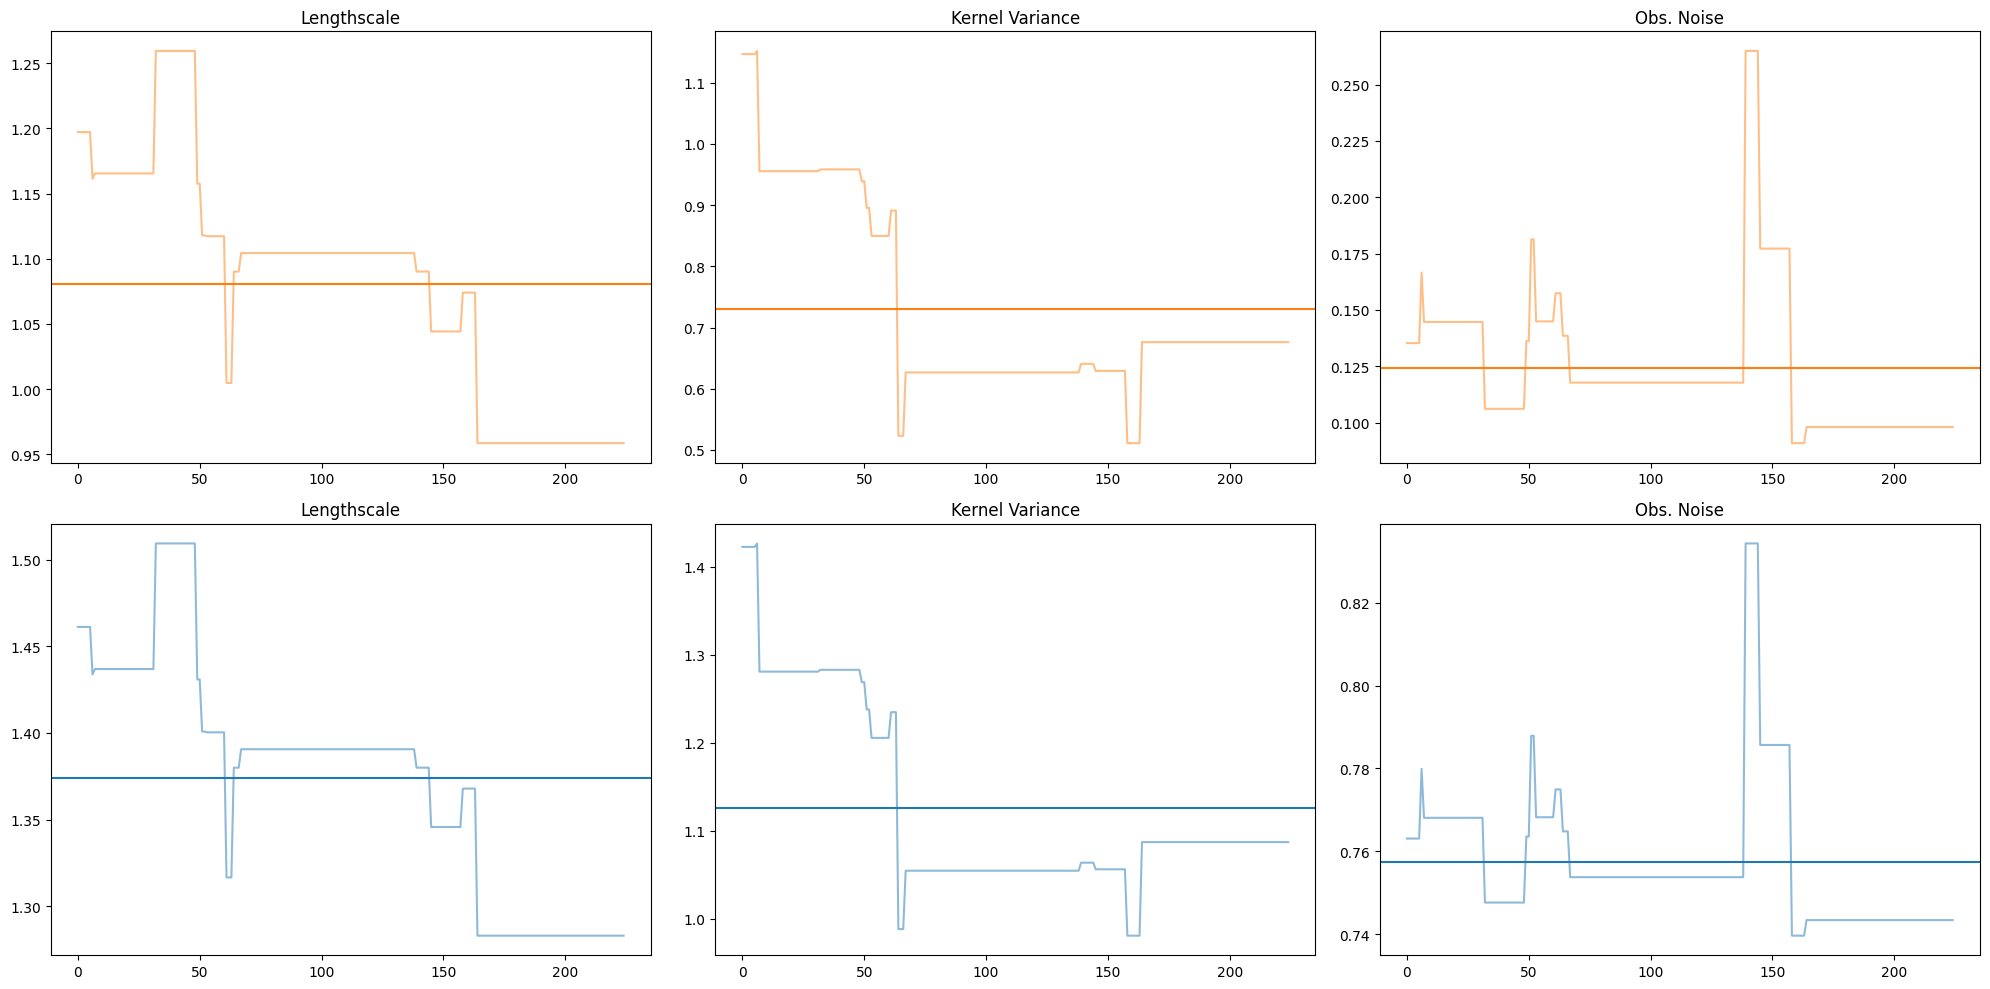

In [14]:
fig, axes = plt.subplots(figsize=(20, 10), ncols=n_params, nrows=2)
titles = ["Lengthscale", "Kernel Variance", "Obs. Noise"]

for i in range(n_params):
    axes[0, i].plot(samples[i], alpha=0.5, color="tab:orange")
    axes[1, i].plot(constrained_sample_list[i], alpha=0.5, color="tab:blue")
    axes[0, i].axhline(y=jnp.mean(samples[i]), color="tab:orange")
    axes[1, i].axhline(y=jnp.mean(constrained_sample_list[i]), color="tab:blue")
    axes[0, i].set_title(titles[i])
    axes[1, i].set_title(titles[i])

plt.tight_layout()

## Making predictions

We’ll now use our MCMC samples to make predictions. For simplicity, we’ll take the average of the samples to give point estimate parameter values for prediction. However, you may wish to draw from the GP posterior for each sample collected during the MCMC phase.

In [15]:
xtest = jnp.linspace(-5.2, 5.2, 500).reshape(-1, 1)
learned_params = array_to_dict([jnp.mean(i) for i in constrained_sample_list])

predictive_dist = likelihood(
    learned_params, posterior(learned_params, D)(xtest)
)

mu = predictive_dist.mean()
sigma = predictive_dist.stddev()

Finally, we plot the learned posterior predictive distribution evaluated at the test points defined above.

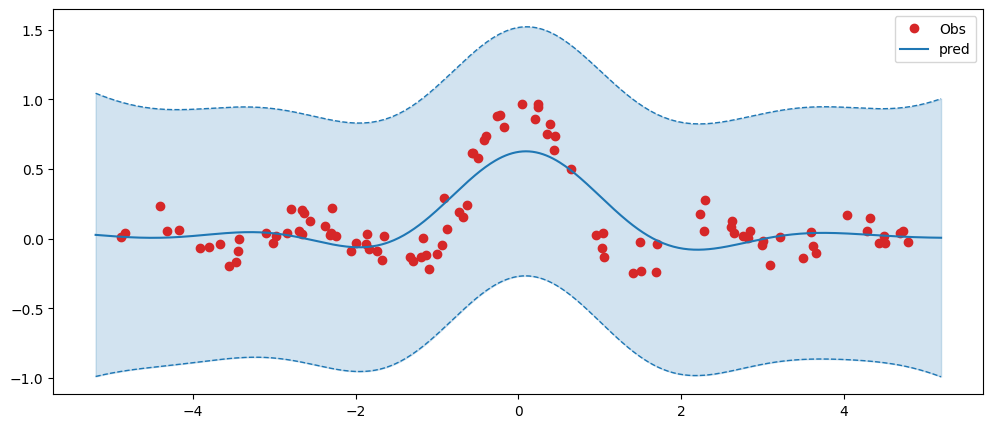

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Obs", color="tab:red")
ax.plot(xtest, mu, label="pred", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    mu.squeeze() - sigma,
    mu.squeeze() + sigma,
    alpha=0.2,
    color="tab:blue",
)
ax.plot(
    xtest, mu.squeeze() - sigma, color="tab:blue", linestyle="--", linewidth=1
)
ax.plot(
    xtest, mu.squeeze() + sigma, color="tab:blue", linestyle="--", linewidth=1
)

ax.legend()

This concludes our tutorial on interfacing TensorFlow Probability with GPJax.
The workflow demonstrated here only scratches the surface regarding the inference possible with a large number of samplers available in TensorFlow probability.

## System configuration

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder (edited by Daniel Dodd)"

Author: Thomas Pinder (edited by Daniel Dodd)

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

gpjax                 : 0.5.8
jaxkern               : 0.0.4
matplotlib            : 3.3.3
jax                   : 0.4.1
tensorflow_probability: 0.19.0

Watermark: 2.3.1

